### Evaluation 

This notebook is meant to serve as an example for how to evaluate the performance of a trained model, and/or compare to the summation of Q_prime for your inputs. Summed Q` represents using a summation rather than routing and is a good indicator of the baseline performance of your model

In [2]:
# Run imports
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import yaml

from ddr._version import __version__
from ddr.validation import (
    Config,
    Metrics,
    plot_box_fig,
    plot_cdf,
    plot_drainage_area_boxplots,
    plot_gauge_map,
)

log = logging.getLogger(__name__)

In [3]:
# Load a config
config_path = "../"
with open("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250901-train/hbv-test-2025-09-02_02-33-05/pydantic_config.yaml") as f:
    config = Config(**yaml.safe_load(f))

In [4]:
# Loading paths to results. We're comparing to summed q_prime as it's a good indicator of if routing is working
summed_q_prime_path_hbv = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/hbv-2025-09-02_08-50-20/summed_q_prime.zarr")  # To obtain this, please run scripts/summed_q_prime.py
summed_q_prime_path_prms = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/hbv-2025-09-02_08-50-20/summed_q_prime.zarr")
summed_q_prime_path_sacsma = Path("/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/hbv-2025-09-02_08-50-20/summed_q_prime.zarr")  # 
predictions_path_hbv = Path(
    "/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250901-train/hbv-test-2025-09-02_02-33-05/model_test.zarr"
)  # To obtain this, please run scripts/ to evaluate a trained model
predictions_path_prms = Path(
    "/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/prms-2025-09-02_08-50-05/summed_q_prime.zarr"
)
predictions_path_sacsma = Path(
    "/projects/mhpi/leoglonz/multiscale/routing/ddr/output/ddr-v0.1.dev146+g192c9f188.d20250902-train/sacsma-2025-09-02_08-49-47/summed_q_prime.zarr"
)

ds_qp_hbv = xr.open_zarr(summed_q_prime_path_hbv)
ds_qp_prms = xr.open_zarr(summed_q_prime_path_prms)
ds_qp_sacsma = xr.open_zarr(summed_q_prime_path_sacsma)

ds_pred_hbv = xr.open_zarr(predictions_path_hbv)
ds_pred_prms = xr.open_zarr(predictions_path_prms)
ds_pred_sacsma = xr.open_zarr(predictions_path_sacsma)


In [17]:
# Get Metrics
results_hbv = []
results_prms = []
results_sacsma = []

ds_qp_ordered_hbv = ds_qp_hbv.sel(gage_ids=ds_pred_hbv.gage_ids.values, time=ds_pred_hbv.time.values)
ds_qp_ordered_prms = ds_qp_prms.sel(gage_ids=ds_pred_prms.gage_ids.values, time=ds_pred_prms.time.values)
ds_qp_ordered_sacsma = ds_qp_sacsma.sel(gage_ids=ds_pred_sacsma.gage_ids.values, time=ds_pred_sacsma.time.values)

# results_hbv.append(Metrics(pred=ds_qp_ordered_hbv.predictions.values, target=ds_qp_ordered_hbv.observations.values))
# results_hbv.append(Metrics(pred=ds_pred_hbv.predictions.values, target=ds_pred_hbv.observations.values))

# results_prms.append(Metrics(pred=ds_qp_ordered_prms.predictions.values, target=ds_qp_ordered_prms.observations.values))
# results_prms.append(Metrics(pred=ds_pred_prms.predictions.values, target=ds_pred_prms.observations.values))

# results_sacsma.append(Metrics(pred=ds_qp_ordered_sacsma.predictions.values, target=ds_qp_ordered_sacsma.observations.values))
# results_sacsma.append(Metrics(pred=ds_pred_sacsma.predictions.values, target=ds_pred_sacsma.observations.values))

results = []


pred_val = (ds_pred_hbv.predictions.values + ds_pred_prms.predictions.values[:,2:] + ds_pred_sacsma.predictions.values[:,2:])/3
target_val = (ds_qp_ordered_hbv.observations.values + ds_qp_ordered_prms.observations.values[:,2:] + ds_qp_ordered_sacsma.observations.values[:,2:])/3
results.append(Metrics(pred=pred_val, target=target_val))

qp = (ds_qp_ordered_hbv.observations.values + ds_qp_ordered_prms.observations.values[:,2:] + ds_qp_ordered_sacsma.observations.values[:,2:])/3
qp_target = (ds_qp_ordered_hbv.observations.values + ds_qp_ordered_prms.observations.values[:,2:] + ds_qp_ordered_sacsma.observations.values[:,2:])/3
results.append(Metrics(pred=qp, target=qp_target))


/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  p_bias = np.sum(pred - target) / np.sum(target) * 100
/projects/mhpi/leoglonz/multiscale/routing/ddr/src/ddr/validation/metrics.py:202: RuntimeWarning: invalid value encountered in scalar divide
  p_bias = np.sum(pred - target) / np.sum(target) * 100
pred contains NaN, check your gradient chain
NoneType: None


ValidationError: 1 validation error for Metrics
  Value error, pred contains NaN, check your gradient chain [type=value_error, input_value={'pred': array([[40.30424..., 5082), dtype=float32)}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/value_error

In [19]:
qp_target.shape, qp.shape

((2776, 5082), (2776, 5082))

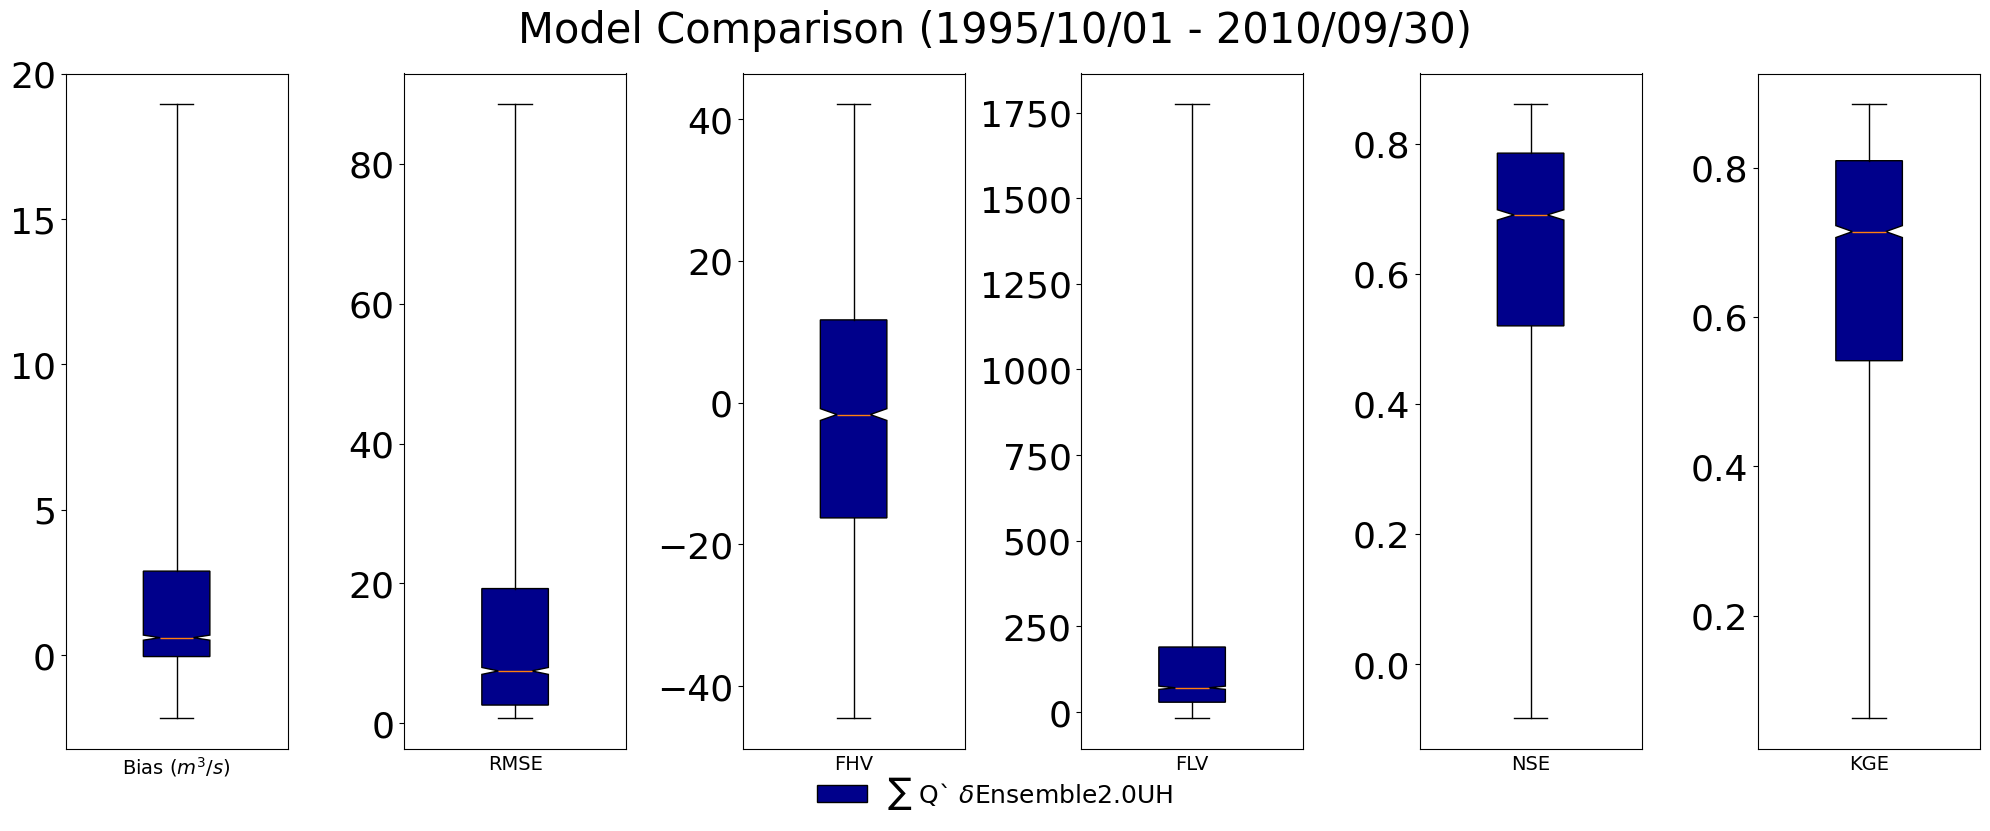

In [16]:
# Define metrics to include in the boxplot
key_list = ["bias", "rmse", "fhv", "flv", "nse", "kge"]
xlabel = [
    r"Bias ($m^3/s$)",
    "RMSE",
    "FHV",
    "FLV",
    "NSE",
    "KGE",
]
dataset_labels = [
    "$\\sum$ Q` $\\delta$Ensemble2.0UH",
    f"ddrv{__version__}",
]

# Create Box Plots
data_box = []
for statStr in key_list:
    temp = []
    for result in results:
        data = dict(result)[statStr]
        if data.size > 0:  # Check if data is not empty
            if statStr == "nse" or statStr == "kge":
                data = np.clip(data, -1, 1)  # Clip NSE and KGE values to [-1, 1]
            data = data[~np.isnan(data)]  # Remove NaNs
            temp.append(data)
    data_box.append(temp)

fig = plot_box_fig(
    data=data_box,
    xlabel_list=xlabel,
    legend_labels=dataset_labels,
    sharey=False,
    figsize=(20, 8),
    legend_font_size=18,
    xlabel_font_size=14,
    tick_font_size=26,
)
fig.patch.set_facecolor("white")
boxPlotName = "Model Comparison (1995/10/01 - 2010/09/30)"
fig.suptitle(boxPlotName, fontsize=30)
plt.rcParams["font.size"] = 22

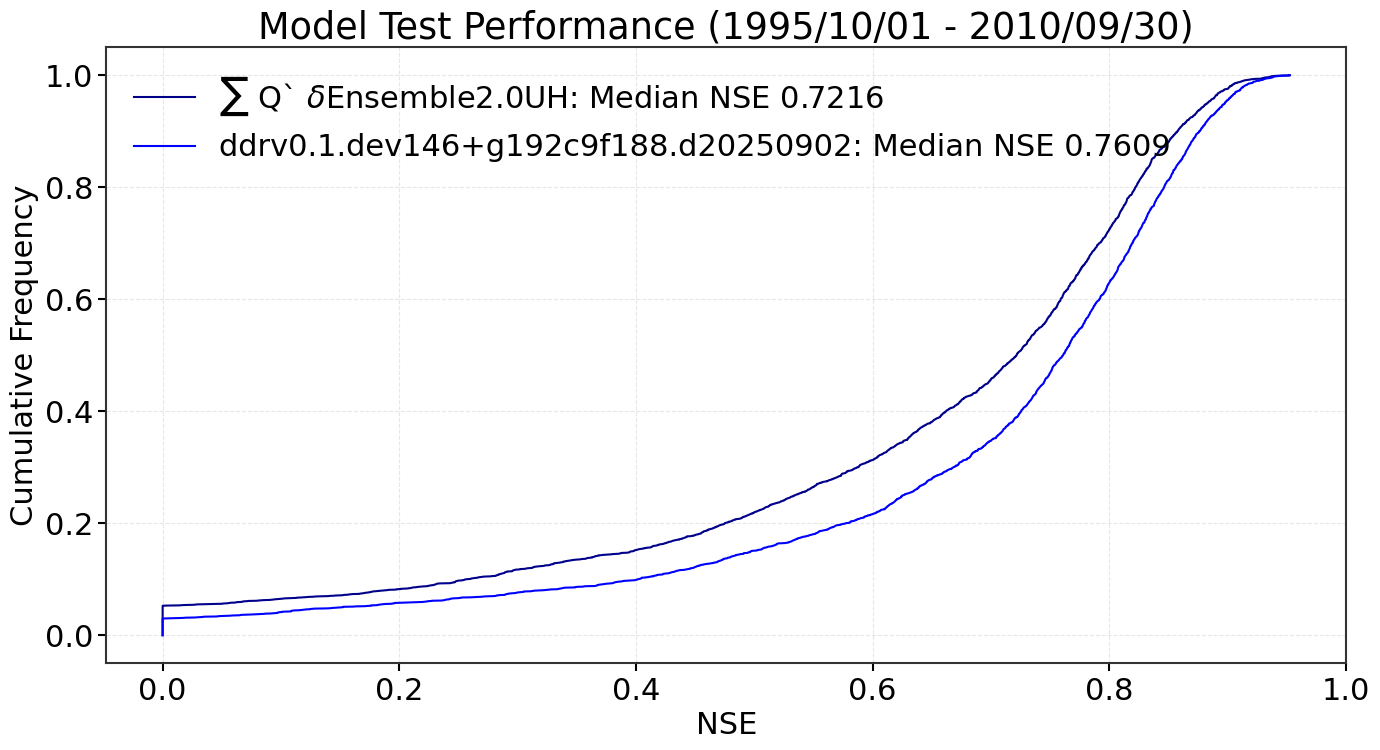

In [28]:
# Plot a CDF
fig, ax = plot_cdf(
    data_list=[np.clip(dict(result)["nse"], 0, None) for result in results],
    title="Model Test Performance (1995/10/01 - 2010/09/30)",
    legend_labels=dataset_labels,
    figsize=(16, 8),
    xlabel="NSE",
    ylabel="Cumulative Frequency",
    reference_line=None,
)
plt.show()

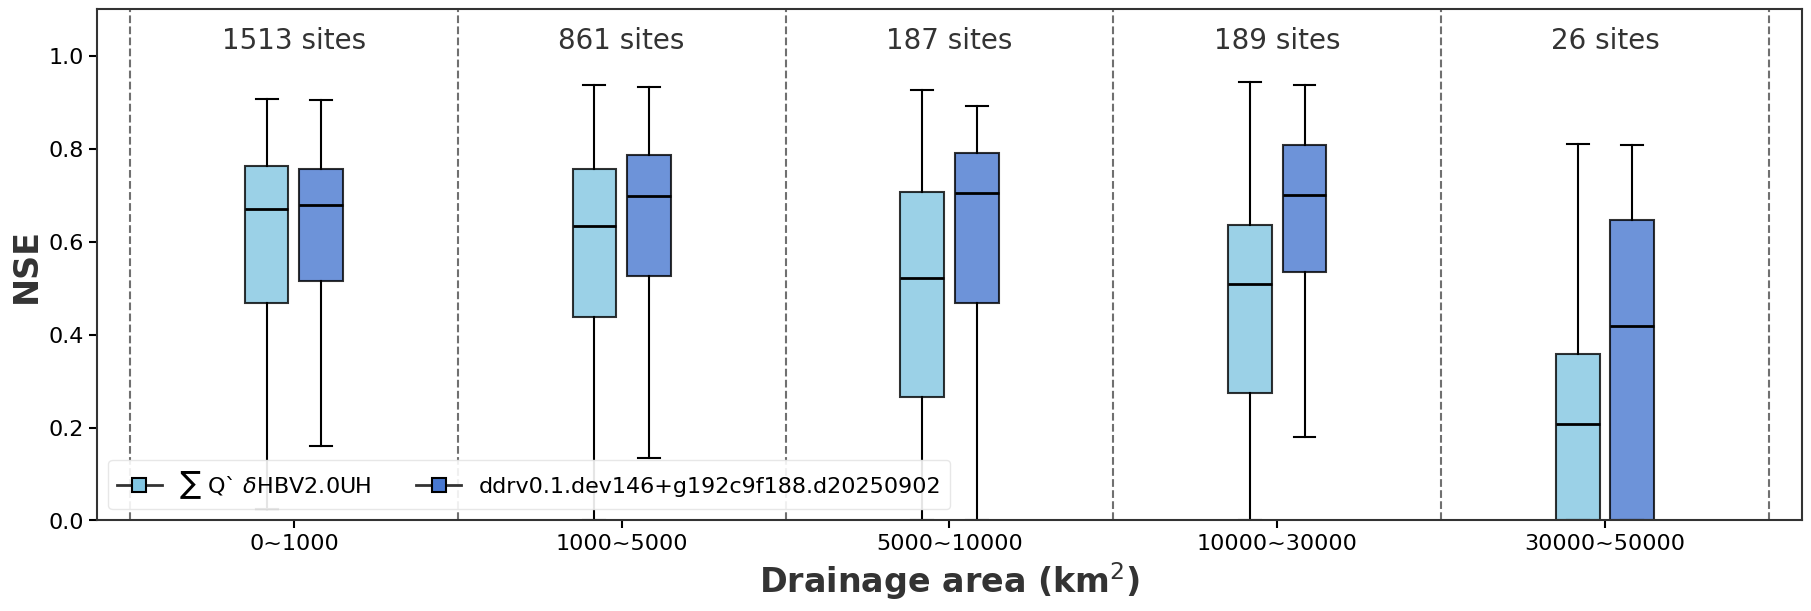

In [22]:
# If you have the gauges.csv file, you can run the following function to break up your code's performance by gauge DA
gages_df = pd.read_csv("training_gauges.csv")
gages_df["STAID"] = gages_df["STAID"].astype(str).str.zfill(8)
gages_df = gages_df.set_index("STAID")
selected_gages = gages_df.loc[ds_pred.gage_ids.values].reset_index()

selected_gages["q_prime_NSE"] = np.clip(results[0].nse, a_min=0.0, a_max=1.0)
selected_gages["ddr_NSE"] = np.clip(results[1].nse, a_min=0.0, a_max=1.0)

fig = plot_drainage_area_boxplots(
    gages=selected_gages, metrics=["q_prime_NSE", "ddr_NSE"], model_names=dataset_labels, show_plot=True
)

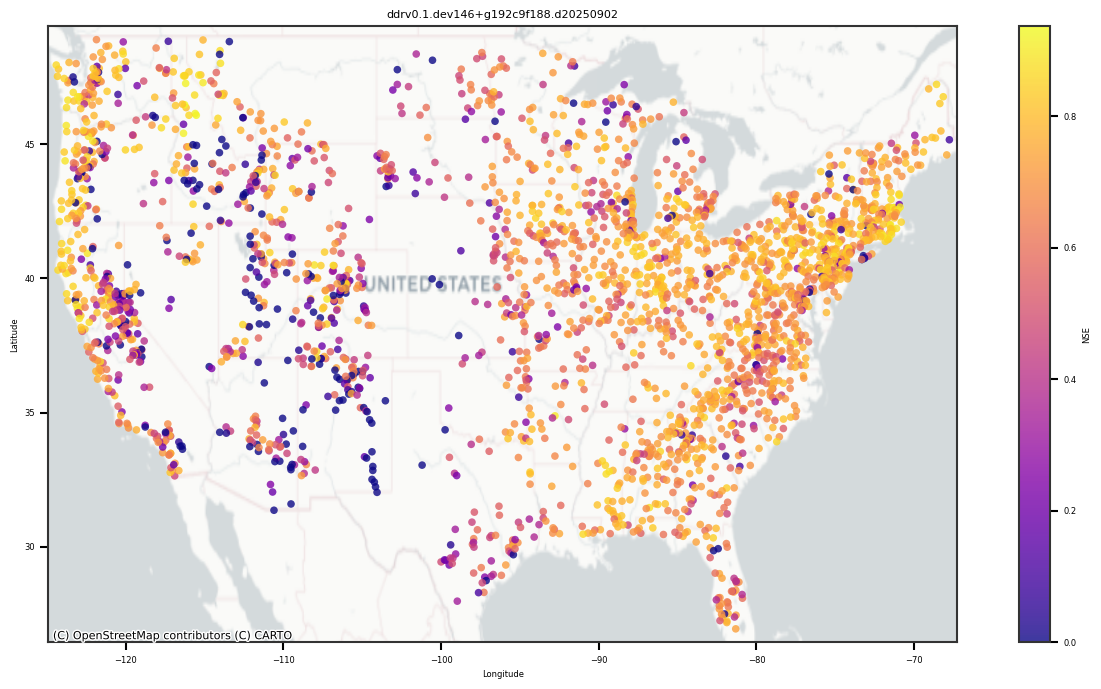

In [23]:
fig = plot_gauge_map(
    gages=selected_gages,
    metric_column="ddr_NSE",
    title=f"ddrv{__version__}",
    show_plot=True,
    colormap="plasma",
    figsize=(16, 8),
    point_size=30,
)